# Reinforcement learning for legged robots

**Student Name : Nayoung KWON**

**Student ID :2400100**

In [1]:
import gymnasium as gym
import stable_baselines3

2024-11-27 22:15:42.413032: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-27 22:15:42.451686: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-27 22:15:42.451699: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-27 22:15:42.453624: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 22:15:42.462351: I tensorflow/core/platform/cpu_feature_guar

Let's import the usual suspects as well:

In [2]:
import matplotlib.pylab as plt
import numpy as np

plt.ion()

# Inverted pendulum environment

The inverted pendulum model is not just a toy model reproducing the properties of real robot models for balancing: as it turns out, the inverted pendulum appears in the dynamics of *any* mobile robot, that is, a model with a floating-base joint at the root of the kinematic tree. (If you are curious: the inverted pendulum is a limit case of the [Newton-Euler equations](https://scaron.info/robotics/newton-euler-equations.html) corresponding to floating-base coordinates in the equations of motion $M \ddot{q} + h = S^T \tau + J_c^T f$, in the limit where the robot [does not vary its angular momentum](https://scaron.info/robotics/point-mass-model.html).) Thus, while we work on a simplified inverted pendulum in this notebook, concepts and tools are those used as-is on real robots, as you can verify by exploring the bonus section.

Gymnasium is mainly a single-agent reinforcement learning API, but it also comes with simple environments, including an inverted pendulum sliding on a linear guide:

In [3]:
with gym.make("InvertedPendulum-v4", render_mode="human") as env:
    action = 0.0 * env.action_space.sample()
    observation, _ = env.reset()
    episode_return = 0.0
    for step in range(200):
        # action[0] = 5.0 * observation[1] + 0.3 * observation[0]
        observation, reward, terminated, truncated, _ = env.step(action)
        episode_return += reward
        if terminated or truncated:
            observation, _ = env.reset()
    print(f"Return of the episode: {episode_return}")

Return of the episode: 200.0


The structure of the action and observation vectors are documented in [Inverted Pendulum - Gymnasium Documentation](https://gymnasium.farama.org/environments/mujoco/inverted_pendulum/).  The observation, in particular, is a NumPy array with four coordinates that we recall here for reference:

| Num | Observation | Min | Max | Unit |
|-----|-------------|-----|-----|------|
|   0 | position of the cart along the linear surface | -Inf | Inf | position (m) |
|   1 | vertical angle of the pole on the cart | -Inf | Inf | angle (rad) |
|   2 | linear velocity of the cart | -Inf | Inf | linear velocity (m/s) |
|   3 | angular velocity of the pole on the cart | -Inf | Inf | anglular velocity (rad/s) |

We will use the following labels to annotate plots:

In [4]:
OBSERVATION_LEGEND = ("pitch", "position", "linear_velocity", "angular_velocity")

Check out the documentation for the definitions of the action and rewards.

# PID control

A *massively* used class of policies is the [PID controller](https://en.wikipedia.org/wiki/Proportional%E2%80%93integral%E2%80%93derivative_controller). Let's say we have a reference observation, like $o^* = [0\ 0\ 0\ 0]$ for the inverted pendulum. Denoting by $e(t) = o^* - o(t)$ the *error* of the system when it observes a given state, a continuous-time PID controller will apply the action:

$$
a(t) = K_p^T e(t) + K_d^T \dot{e}(t) + K_i^T \int e(\tau) \mathrm{d} \tau
$$

where $K_{p}, K_i, K_d \in \mathbb{R}^4$ are constants called *gains* and tuned by the user. In discrete time the idea is the same:

$$
a_k = K_p^T e_k + K_d^T \frac{e_k - e_{k-1}}{\delta t} + K_i^T \sum_{i=0}^{k} e_i {\delta t}
$$

Compared to the PD controller we tuned in the previous exercise, there is an additional integrator term in the PID controller. The I-term ensures that steady-state regulation (tracking a fixed reference) error is zero when there is a fixed disturbance. However, PID controller is also harder to stabilize than the PD controller can be dangerous in practice if unstable.

Let's refactor the rolling out of our episode into a standalone function:

In [5]:
def rollout_from_env(env, policy):
    episode = []
    observation, _ = env.reset()
    episode.append(observation)
    for step in range(1000):
        action = policy(observation)
        observation, reward, terminated, truncated, _ = env.step(action)
        episode.extend([action, reward, observation])
        if terminated or truncated:
            return episode
    return episode

def rollout(policy, show: bool = True):
    kwargs = {"render_mode": "human"} if show else {}
    with gym.make("InvertedPendulum-v4", **kwargs) as env:
        episode = rollout_from_env(env, policy)
    return episode

## Question 1: Write a PID controller that balances the inverted pendulum

You can use global variables to store the (discrete) derivative and integral terms, this will be OK here as we only rollout a single trajectory:

In [135]:
Kp = np.array([-.8, .9, -1, -1.6])
Kd = np.array([-.1, -.1, -.3, -.1])
Ki = np.array([-.2, -.3, -.1, -.1])

#target
target = np.zeros(4) 
dt = 0.02

previous_error=np.zeros(4)
integral_error = np.zeros(4)

def pid_policy(observation: np.ndarray) -> np.ndarray:
    global previous_error, integral_error, target
    #error
    error = target - observation

    # Calculate PID terms
    derivative = (error - previous_error) / dt
    integral_error += error * dt
    my_action_value = ((Kp @ error) + (Kd @ derivative) + (Ki@ integral_error))

    previous_error = error
    return np.array([my_action_value])

episode = rollout(pid_policy, show=False)

You can look at the system using `show=True`, but intuition usually builds faster when looking at relevant plots:

'\nHere I am only printing the first 350 for better visualization\n'

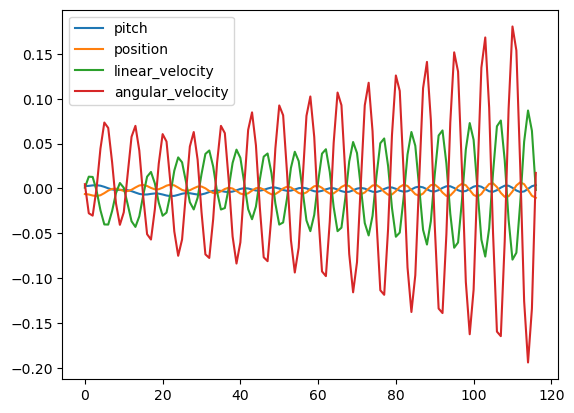

In [137]:
observations = np.array(episode[:350:3])

plt.plot(observations)
plt.legend(OBSERVATION_LEGEND)

"""
Here I am only printing the first 350 for better visualization
"""

Can you reach the full reward of 1000 steps?

In [8]:
print(f"Return of the episode: {sum(episode[2::3])}")

Return of the episode: 1000.0


# Policy optimization

Let us now train a policy, parameterized by a multilayer perceptron (MLP), to maximize the expected return over episodes on the inverted pendulum environment.

## Our very first policy

We will use the proximal policy optimization (PPO) algorithm for training, using the implementation from Stable Baselines3: [PPO - Stable Baselines3 documentation](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html).

In [9]:
from stable_baselines3 import PPO

with gym.make("InvertedPendulum-v4", render_mode="human") as env:
    first_policy = PPO("MlpPolicy", env, verbose=0)
    first_policy.learn(total_timesteps=1000, progress_bar=False)

By instantiating the algorithm with no further ado, we let the library decide for us on a sane set of default hyperparameters, including:

- Rollout buffers of `n_steps = 2048` steps, which we will visit `n_epochs = 10` times with mini-batches of size `batch_size = 64`.
- Clipping range: ``0.2``.
- No entropy regularization.
- Learning rate for the Adam optimizer: ``3e-4``
- Policy and value-function network architectures: two layers of 64 neurons with $\tanh$ activation functions.

We then called the `learn` function to execute PPO over a fixed total number of timesteps, here just a thousand.

Rendering actually took a significant chunk of time. Let's instantiate and keep an environment open without rendering:

In [10]:
env = gym.make("InvertedPendulum-v4")

We can use it to train much more steps in roughly the same time, reporting training metrics every `n_steps` step:

In [11]:
second_policy = PPO("MlpPolicy", env, verbose=1)
second_policy.learn(total_timesteps=10_000, progress_bar=False)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.8      |
|    ep_rew_mean     | 7.8      |
| time/              |          |
|    fps             | 370      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10.2        |
|    ep_rew_mean          | 10.2        |
| time/                   |             |
|    fps                  | 438         |
|    iterations           | 2           |
|    time_elapsed         | 9           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.020868603 |
|    clip_fraction        | 0.191       |
|    clip_range           | 0.2         |
|    entropy_loss  

Let's see how this policy performs:

In [12]:
def policy_closure(policy):
    """Utility function to turn our policy instance into a function.

    Args:
        policy: Policy to turn into a function.
        
    Returns:
        Function from observation to policy action.
    """
    def policy_function(observation):
        action, _ = policy.predict(observation)
        return action
    return policy_function

In [13]:
episode = rollout(policy_closure(second_policy), show=True)

Okay, it looks like we didn't train for long enough!

## Monitoring performance during training

Let's train for longer, and use TensorBoard to keep track. We don't know how long training will take so let's put a rather large total number of steps (you can interrupt training once you observed convergence in TensorBoard):

In [14]:
erudite_policy = PPO(
    "MlpPolicy",
    env,
    tensorboard_log="./inverted_pendulum_tensorboard/",
    verbose=0,
)

erudite_policy.learn(
    total_timesteps=1_000_000,
    progress_bar=False,
    tb_log_name="erudite",
)

KeyboardInterrupt: 

Run TensorBoard on the directory thus created to open a dashboard in your Web browser:

```
tensorboard --logdir ./inverted_pendulum_tensorboard/
```

The link will typically be http://localhost:6006 (port number increases if you run TensorBoard multiple times in parallel). Tips:

- Click the Settings icon in the top-right corner and enable "Reload data"
- Uncheck "Ignore outliers in chart scaling" (your preference)

## Saving our policy

Now that you spent some computing to optimize an actual policy, better save it to disk:

In [15]:
erudite_policy.save("pendulum_erudite")

You can then reload it later by:

In [16]:
erudite_policy = PPO.load("pendulum_erudite", env=env)

In [17]:
erudite_episode = rollout(policy_closure(erudite_policy), show=False)

In [18]:
print(f"Return of the episode: {sum(erudite_episode[2::3])}")

Return of the episode: 1000.0


'\nHere I am only printing the first 350 for better visualization\n'

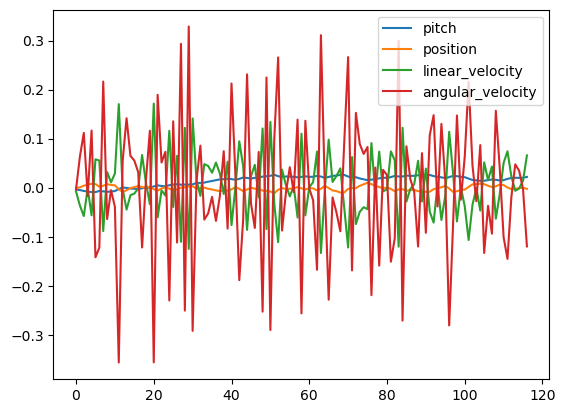

In [144]:
erudite_observations = np.array(erudite_episode[:350:3])

plt.plot(erudite_observations)
plt.legend(OBSERVATION_LEGEND)

"""
Here I am only printing the first 350 for better visualization
"""

## Question 2: How many steps does it take to train a successful policy?

We consider a policy successful if it consistently achieves the maximum return of 1000.

## A more realistic environment

Real systems suffer from the two main issues we saw in the [Perception and estimation](https://scaron.info/robotics-mva/#5-perception-estimation) class: *bias* and *variance*. In this section, we model bias in actuation and perception by adding delays (via low-pass filtering) to respectively the action and observation vectors. Empirically this is an effective model, as for instance it contributes to sim2real transfer on Upkie. To add these delays, we use an [`environment wrapper`](https://gymnasium.farama.org/api/wrappers/), which is a convenient way to compose environments, used in both the Gymnasium and Stable Baselines3 APIs:

In [20]:
class DelayWrapper(gym.Wrapper):
    def __init__(self, env, time_constant: float = 0.2):
        """Wrap environment with some actuation and perception modeling.

        Args:
            env: Environment to wrap.
            time_constant: Constant of the internal low-pass filter, in seconds.
                Feel free to play with different values but leave it to the default
                of 0.2 seconds when handing out your homework.

        Note:
            Delays are implemented by a low-pass filter. The same time constant
            is used for both actions and observations, which is not realistic, but
            makes for less tutorial code ;)
        """
        alpha = env.dt / time_constant
        assert 0.0 < alpha < 1.0
        super().__init__(env)
        self._alpha = alpha
        self._prev_action = 0.0 * env.action_space.sample()
        self._prev_observation = np.zeros(4)

    def low_pass_filter(self, old_value, new_value):
        return old_value + self._alpha * (new_value - old_value)
        
    def step(self, action):
        new_action = self.low_pass_filter(self._prev_action, action)
        observation, reward, terminated, truncated, info = self.env.step(new_action)
        new_observation = self.low_pass_filter(self._prev_observation, observation)
        self._prev_action = new_action
        self._prev_observation = new_observation
        return new_observation, reward, terminated, truncated, info

delay_env = DelayWrapper(env)

/home/nj/miniconda3/envs/robotics_course/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.dt to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.dt` for environment variables or `env.get_wrapper_attr('dt')` that will search the reminding wrappers.
  logger.warn(


We can check how our current policy fares against the delayed environment. Spoiler alert: no great.

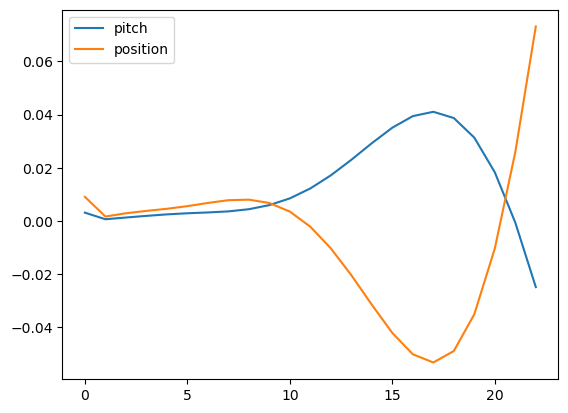

In [21]:
delay_episode = rollout_from_env(delay_env, policy_closure(erudite_policy))
delay_observations = np.array(delay_episode[::3])

plt.plot(delay_observations[:, :2])
plt.legend(OBSERVATION_LEGEND)

## Question 3: Can't we just re-train a policy on the new environment?

At this point of the tutorial this is a rethorical question, but we should check anyway. Re-train a policy on the delayed environment and comment on its performance:

In [22]:
# Your code here

# initialize the delayed environment
delayed_env = DelayWrapper(env)
# new policy for the delayed environment
delayed_policy = PPO("MlpPolicy", delayed_env, verbose=0, tensorboard_log="./inverted_pendulum_tensorboard/")

# Train the new policy
delayed_policy.learn(total_timesteps=1_000_000, tb_log_name="delayed_policy",progress_bar=False)

delay_episode = rollout_from_env(delay_env, policy_closure(delayed_policy), show=False)
delayed_observations = np.array(delay_episode[::3])

KeyboardInterrupt: 

In [23]:
delayed_policy.save("delayed_policy")
delayed_policy = PPO.load("delayed_policy", env=delay_env)

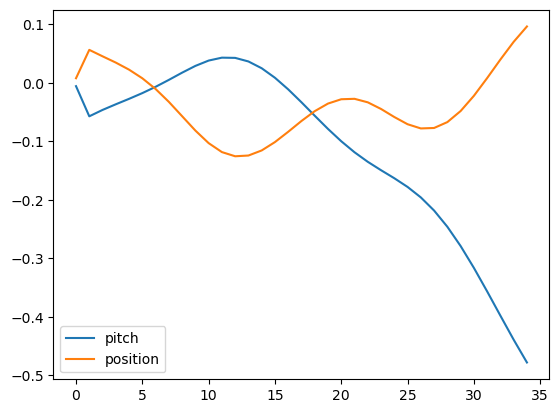

In [36]:
delay_episode = rollout_from_env(delay_env, policy_closure(delayed_policy))
observations = np.array(delay_episode[::3])

plt.plot(observations[:, :2])
plt.legend(OBSERVATION_LEGEND)

In [37]:
print(f"Return of the episode: {sum(delay_episode[2::3])}")

Return of the episode: 34.0


## The Real Question 3: Why do delays degrade both runtime and training performance?

Loss in runtime performance refers to the one we observed when executing a policy trained without delay on an environment with delays. Loss in training performance refers to the fact that, even when we train a new policy on the environment with delays, by the end of training it does not achieve maximum return.

Propose and implement a way to overcome this. Train the resulting policy in a variable called `iron_policy`.

In [38]:
class CustumDelayWrapper(gym.Wrapper):
    def __init__(self, environment, time_delay: float = 0.2):
        super().__init__(environment)
        self.delay_factor = environment.dt / time_delay
        assert 0.0 < self.delay_factor < 1.0, "Delay factor must be between 0 and 1."
        self.previous_action = np.zeros_like(environment.action_space.sample())
        self.previous_observation = np.zeros(environment.observation_space.shape)

    def delay_filter(self, old, new):
        return old + self.delay_factor * (new - old)

    def reset(self, **kwargs):
        observation, info = self.env.reset(**kwargs)
        self.previous_observation = observation
        return observation, info

    def step(self, action):
        filtered_action = self.delay_filter(self.previous_action, action)
        observation, reward, done, truncated, info = self.env.step(filtered_action)
        filtered_observation = self.delay_filter(self.previous_observation, observation)

        self.previous_action = filtered_action
        self.previous_observation = filtered_observation

        return filtered_observation, reward, done, truncated, info


class PredictiveEnv(gym.Wrapper):
    def __init__(self, environment, num_stacks):
        super().__init__(environment)
        self.num_stacks = num_stacks
        self.obs_buffer = np.zeros((num_stacks,) + environment.observation_space.shape)

        # update observation space to represent stacked observations
        self.observation_space = gym.spaces.Box(
            low=np.repeat(environment.observation_space.low, num_stacks),
            high=np.repeat(environment.observation_space.high, num_stacks),
            dtype=environment.observation_space.dtype,
        )

    def reset(self, **kwargs):
        observation, info = self.env.reset(**kwargs)
        self.obs_buffer[:] = observation  #initialize buffer with the first observation
        return self._get_stacked_observation(), info

    def step(self, action):
        observation, reward, done, truncated, info = self.env.step(action)
        self.obs_buffer = np.roll(self.obs_buffer, shift=-1, axis=0)
        self.obs_buffer[-1] = observation

        return self._get_stacked_observation(), reward, done, truncated, info

    def _get_stacked_observation(self):
        return self.obs_buffer.flatten()

In [39]:
delayed_env = CustumDelayWrapper(env)
iron_env = PredictiveEnv(delayed_env, 5)

In [40]:
iron_policy = PPO("MlpPolicy", iron_env, verbose=0, tensorboard_log="./inverted_pendulum_tensorboard/")

In [41]:
iron_policy.learn(total_timesteps=1_000_000, tb_log_name="iron_policy", progress_bar=False)

KeyboardInterrupt: 

In [42]:
iron_policy.save("iron_policy")

In [43]:
iron_policy = PPO.load("iron_policy", env=iron_env)

In [44]:
iron_episode = rollout_from_env(iron_env, policy_closure(iron_policy))
observations = np.array(iron_episode[::3])

Roll out an episode and plot the outcome to show that your policy handles delays properly.

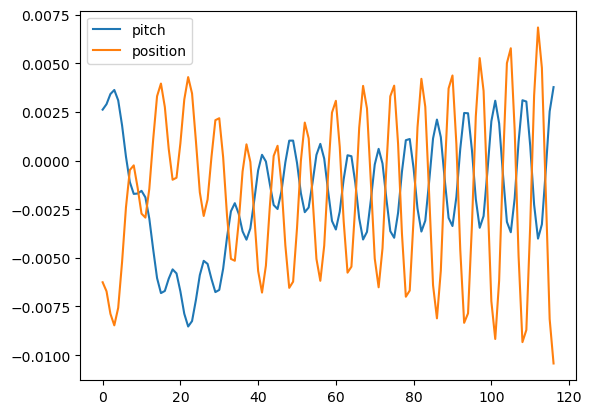

In [145]:
plt.plot(np.array(observations)[:350, :2])
plt.legend(OBSERVATION_LEGEND)

"""
Here I am only printing the first 350 for better visualization
"""

## Question 4: Can you improve sampling efficiency?

This last question is open: what can you change in the pipeline to train a policy that achieves maximum return using less samples? Report on at least one thing that allowed you to train with less environment steps.

Here is a state-of-the-art™ utility function if you want to experiment with scheduling some of the ``Callable[[float], float]`` [hyperparameters](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html#parameters):

In [60]:
def lr_schedule(progress: float) -> float:
    return 1e-3 + progress * (1e-4 - 1e-3)

In [61]:
iron_policy_adjusted_lr = PPO(
    "MlpPolicy",
    iron_env,
    learning_rate=lr_schedule,
    verbose=0,
    tensorboard_log="./inverted_pendulum_tensorboard/"
)
iron_policy_adjusted_lr.learn(total_timesteps=1_000_000, tb_log_name="iron_policy_adjusted_lr",progress_bar=False)

KeyboardInterrupt: 

In [86]:
iron_policy_adjusted_lr.save("iron_policy_adjusted_lr")

In [87]:
# Evaluate its performance
iron_policy_adjusted_lr = PPO.load("iron_policy_adjusted_lr", env=iron_env)
iron_episode_adjusted_lr = rollout_from_env(iron_env, policy_closure(iron_policy_adjusted_lr))
observations_adjusted_lr = np.array(iron_episode_adjusted_lr[::3])

'\nHere I am only printing the first 350 for better visualization\n'

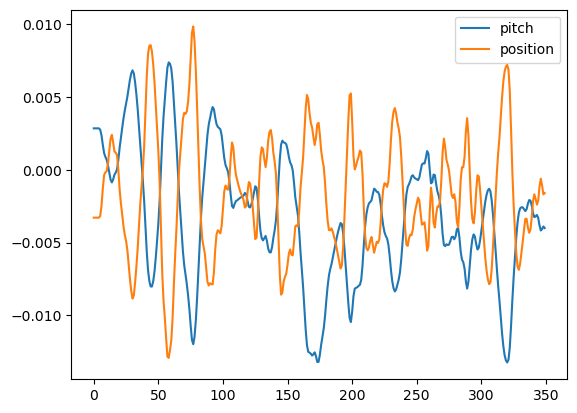

In [146]:
plt.plot(np.array(observations_adjusted_lr)[:350,:2]) #printing only first 350
plt.legend(OBSERVATION_LEGEND)

"""
Here I am only printing the first 350 for better visualization
"""

And here is a wrapper template if you want to experiment with reward shaping:

In [107]:
class CustomRewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)

    def step(self, action):
        observation, reward, terminated, truncated, info = self.env.step(action)
        pole_angle = observation[1]
        new_reward = reward - (abs(pole_angle) * 0.1) 
        return observation, new_reward, terminated, truncated, info

custom_reward_env = CustomRewardWrapper(iron_env)



In [108]:
iron_policy_custum_adjusted_lr = PPO(
    "MlpPolicy", 
    custom_reward_env,
    learning_rate=lr_schedule,
    verbose=0,
    tensorboard_log="./inverted_pendulum_tensorboard/"
)

In [109]:
iron_policy_custum_adjusted_lr.learn(total_timesteps=1_000_000, tb_log_name="iron_policy_custum")

KeyboardInterrupt: 

In [115]:
iron_policy_custum_adjusted_lr.save("iron_policy_custum_adjusted_lr")

In [116]:
iron_policy_custum_adjusted_lr = PPO.load("iron_policy_custum_adjusted_lr", env=custom_reward_env)
iron_episode_custum_adjusted_lr = rollout_from_env(custom_reward_env, policy_closure(iron_policy_custum_adjusted_lr))
observations_custum_adjusted_lr = np.array(iron_episode_custum_adjusted_lr[::3])

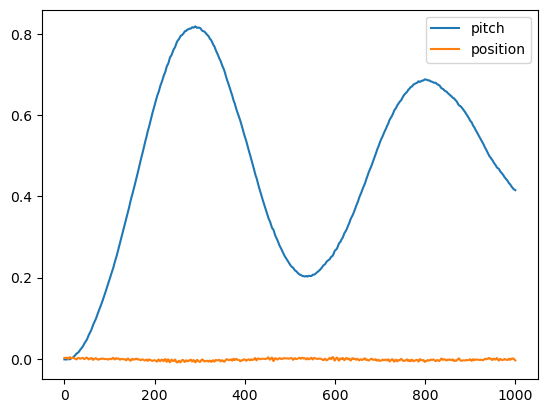

In [120]:
plt.plot(np.array(observations_custum_adjusted_lr)[:, :2])
plt.legend(OBSERVATION_LEGEND)

# Bonus: training a policy for a real robot

This section is entirely optional and will only work on Linux or macOS. In this part, we follow the same training pipeline but with the open source software of [Upkie](https://hackaday.io/project/185729-upkie-wheeled-biped-robots).

## Setup

<img src="https://user-images.githubusercontent.com/1189580/170496331-e1293dd3-b50c-40ee-9c2e-f75f3096ebd8.png" style="height: 100px" align="right" />

First, make sure you have a C++ compiler (setup one-liners: [Fedora](https://github.com/upkie/upkie/discussions/100), [Ubuntu](https://github.com/upkie/upkie/discussions/101)). You can run an Upkie simulation right from the command line. It won't install anything on your machine, everything will run locally from the repository:

```console
git clone https://github.com/upkie/upkie.git
cd upkie
git checkout fb9a0ab1f67a8014c08b34d7c0d317c7a8f71662
./start_simulation.sh
cd ..
pip install upkie
```

**NB:** this tutorial is written for the specific commit checked out above. If some instructions don't work it's likely you forgot to check it out.

## Stepping the environment

If everything worked well, you should be able to step an environment as follows:

In [121]:
import warnings
warnings.filterwarnings("ignore")

In [122]:
import gymnasium as gym
import upkie.envs

upkie.envs.register()

episode_return = 0.0
with gym.make("UpkieGroundVelocity-v3", frequency=200.0) as env:
    observation, _ = env.reset()  # connects to the spine (simulator or real robot)
    action = 0.0 * env.action_space.sample()
    for step in range(1000):
        pitch = observation[0]
        action[0] = 10.0 * pitch  # 1D action: [ground_velocity]
        observation, reward, terminated, truncated, _ = env.step(action)
        episode_return += reward
        if terminated or truncated:
            observation, _ = env.reset()

print(f"We have stepped the environment {step + 1} times")
print(f"The return of our episode is {episode_return}")

[2024-11-27 23:21:48,324] [warning] UpkieGroundVelocity rate limiter is late by -0.900000 [ms] (rate_limiter.py:106)
[2024-11-27 23:21:48,324] [warning] ground_velocity=-15.314979479978243 clamped to lower=-1.0 (clamp.py:54)
[2024-11-27 23:21:51,626] [warning] UpkieGroundVelocity rate limiter is late by -3.900000 [ms] (rate_limiter.py:106)


We have stepped the environment 1000 times
The return of our episode is 346.37573886262976


(If you see a message "Waiting for spine /vulp to start", it means the simulation is not running.)

We can double-check the last observation from the episode:

In [123]:
def report_last_observation(observation):
    print("The last observation of the episode is:")
    print(f"- Pitch from torso to world: {observation[0]:.2} rad")
    print(f"- Ground position: {observation[1]:.2} m")
    print(f"- Angular velocity from torso to world in torso: {observation[2]:.2} rad/s")
    print(f"- Ground velocity: {observation[3]:.2} m/s")
    
report_last_observation(observation)

The last observation of the episode is:
- Pitch from torso to world: 0.001 rad
- Ground position: -0.084 m
- Angular velocity from torso to world in torso: 0.0044 rad/s
- Ground velocity: 0.0033 m/s


## Question B1: PID control

Adapt your code from Question 1 to this environment:

In [126]:
import numpy as np

upkie.envs.register()

previous_error = 0.0
integral_error = 0.0
dt = 1.0 / 200  

def policy_b1(observation: np.ndarray) -> np.ndarray:
    global previous_error, integral_error
    pitch = observation[0]  
    desired_pitch = 0.0

    error = desired_pitch - pitch

    Kp = -150.0 
    Kd = -20.0
    Ki = -20.0

    derivative = (error - previous_error) / dt
    integral_error += error * dt

    force = (Kp * error) + (Kd * derivative)
    action = np.clip(force, -1.0, 1.0)
    previous_error = error

    return np.array([action])


def run(policy, nb_steps: int):
    episode_return = 0.0
    with gym.make("UpkieGroundVelocity-v3", frequency=200.0) as env:
        observation, _ = env.reset()  # connects to the spine (simulator or real robot)
        for step in range(nb_steps):
            action = policy_b1(observation)
            observation, reward, terminated, truncated, _ = env.step(action)
            episode_return += reward
            if terminated or truncated:
                print("Fall detected!")
                return episode_return, step
    report_last_observation(observation)
    return episode_return, step


episode_return, step = run(policy_b1, 1000)
print(f"We have stepped the environment {step + 1} times")
print(f"The return of our episode is {episode_return}")

[2024-11-27 23:22:25,280] [warning] UpkieGroundVelocity rate limiter is late by -5.300000 [ms] (rate_limiter.py:106)
[2024-11-27 23:22:25,316] [warning] UpkieGroundVelocity rate limiter is late by -9.700000 [ms] (rate_limiter.py:106)


The last observation of the episode is:
- Pitch from torso to world: -0.06 rad
- Ground position: -2.7 m
- Angular velocity from torso to world in torso: 0.12 rad/s
- Ground velocity: -0.84 m/s
We have stepped the environment 1000 times
The return of our episode is -633.5554451044529


## Training a new policy

The Upkie repository ships three agents based on PID control, model predictive control and reinforcement learning. We now focus on the latter, called the "PPO balancer".

Check that you can run the training part by running, from the root of the repository:

```
./tools/bazel run //agents/ppo_balancer:train -- --nb-envs 1 --show
```

A simulation window should pop, and verbose output from SB3 should be printed to your terminal.

By default, training data will be logged to `/tmp`. You can select a different output path by setting the `UPKIE_TRAINING_PATH` environment variable in your shell. For instance:

```
export UPKIE_TRAINING_PATH="${HOME}/src/upkie/training"
```

Run TensorBoard from the training directory:

```
tensorboard --logdir ${UPKIE_TRAINING_PATH}  # or /tmp if you keep the default
```

Each training will be named after a word picked at random in an English dictionary.

## Selecting the number of processes

We can increase the number of parallel CPU environments ``--nb-envs`` to a value suitable to your computer. Let training run for a minute and check `time/fps`. Increase the number of environments and compare the stationary regime of `time/fps`. You should see a performance increase when adding the first few environments, followed by a declined when there are two many parallel processes compared to your number of CPU cores. Pick the value that works best for you.

## Running a trained policy

Copy the file `final.zip` from your trained policy directory to `agents/ppo_balancer/policy/params.zip`. Start a simulation and run the policy by:

```
./tools/bazel run //agents/ppo_balancer
```

What kind of behavior do you observe?

## Question B2: Improve this baseline

The policy you are testing here is not the one we saw in class. Open question: improve on it using any of the methods we discussed. Measure the improvement by `ep_len_mean` or any other quantitative criterion: